<a href="https://colab.research.google.com/github/ciastirfry/MSE800/blob/master/MSE802_A2_Task1_BellState_Cirq_QUOKKA_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSE802 – Assessment 2, Task 1 (Entanglement Demonstration with Cirq)

###Author’s Name	: Fredierick Saladas
###Student ID	: 270609973@yoobeestudent.ac.nz
###College		: Yoobee College of Creative Innovation
###Course		: MSE802 Quantum Computing
###Supervisor 	: Dr. Arun Kumar
###Date		 	: 15 November 2025

**Goal:** Prepare the Bell state $|\Phi^+\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$ using Cirq, package the circuit for a Quokka‑like QA device (OpenQASM + JSON), and *simulate* device results using ideal probabilities (**no in‑built simulator**).

**This notebook includes:**
1) Circuit construction in Cirq (Hadamard + CNOT)  
2) OpenQASM export and JSON "job" payload (ready to POST to an API)  
3) A no-simulator "execution": draw samples from the *ideal* distribution  
4) Result interpretation and visualization (bar chart)

**Constraints met**
- Framework: Cirq only for circuit authoring
- No `cirq.Simulator` or other quantum simulators
- Modular code with inline documentation

*Tested with: Python 3.10+, Cirq 1.x*


## (Optional) Environment setup
If running in a clean Colab/Notebook environment, **run this cell** to install Cirq.


In [1]:
# Uncomment to install on Colab or a fresh environment
!pip install --quiet "cirq>=1.2,<2.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.8 MB/s eta 0:00:00


## Imports & Global Config

In [2]:
import json
import math
import random
from collections import Counter
from dataclasses import dataclass
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import cirq

# Reproducibility for the mock device samples
random.seed(42)


## Data Structures
Lightweight containers for job submission and result payloads.


In [4]:
@dataclass
class QAJob:
    """Container for a Quokka-like job submission."""
    qasm: str
    shots: int
    circuit_name: str
    target_device: str = "quokka-qpu-v1"
    extra_metadata: Dict = None

    def to_payload(self) -> Dict:
        return {
            "device": self.target_device,
            "metadata": {
                "name": self.circuit_name,
                **(self.extra_metadata or {})
            },
            "program": {
                "language": "openqasm",
                "version": "2.0",
                "source": self.qasm
            },
            "execution": {
                "shots": self.shots,
                "measurement_key": "m"
            }
        }


@dataclass
class QAResult:
    """Minimal view of a QA device response for histogram-like results."""
    counts: Dict[str, int]
    shots: int

    @classmethod
    def from_payload(cls, payload: Dict) -> "QAResult":
        results = payload.get("results", {})
        return cls(counts=results.get("counts", {}), shots=results.get("shots", 0))


## Circuit Construction (Cirq)

We prepare $|\Phi^+\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$ using:
- $H$ on qubit 0, then
- CNOT with control=qubit 0 and target=qubit 1,
then measure in the Z basis with a known measurement key.


In [5]:
def build_bell_circuit(
    qubit_names: Tuple[str, str] = ("q0", "q1"),
    measure_key: str = "m"
) -> cirq.Circuit:
    """Build a circuit that prepares |Φ⁺⟩ and measures in Z-basis.

    Args:
        qubit_names: Names for the two qubits (control, target).
        measure_key: Measurement key string for final measurement.

    Returns:
        cirq.Circuit
    """
    q0, q1 = [cirq.NamedQubit(n) for n in qubit_names]

    circuit = cirq.Circuit()
    circuit.append(cirq.H(q0))
    circuit.append(cirq.CNOT(q0, q1))
    # Measure with explicit key and qubit order (q0 is LSB, q1 is MSB here)
    circuit.append(cirq.measure(q0, q1, key=measure_key))
    return circuit

bell_circuit = build_bell_circuit()
print("Cirq circuit:")
print(bell_circuit)


Cirq circuit:
q0: ───H───@───M('m')───
           │   │
q1: ───────X───M────────


## OpenQASM Export

Convert the Cirq circuit to **OpenQASM 2.0**. Many hardware backends accept QASM.


In [6]:
def circuit_to_qasm(circuit: cirq.Circuit) -> str:
    """Convert a Cirq circuit to OpenQASM 2.0."""
    return cirq.qasm(circuit)

qasm_source = circuit_to_qasm(bell_circuit)
print("OpenQASM 2.0 export:\n")
print(qasm_source)


OpenQASM 2.0 export:

// Generated from Cirq v1.6.1

OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [q0, q1]
qreg q[2];
creg m_m[2];


h q[0];
cx q[0],q[1];

// Gate: cirq.MeasurementGate(2, cirq.MeasurementKey(name='m'), ())
measure q[0] -> m_m[0];
measure q[1] -> m_m[1];



## Build a JSON Job Payload

Wrap the QASM program in a JSON payload for a Quokka-like API.
Replace placeholders when submitting to a real device.


In [7]:
def build_job_payload(qasm: str, shots: int = 2000, circuit_name: str = "bell_phi_plus") -> Dict:
    job = QAJob(qasm=qasm, shots=shots, circuit_name=circuit_name, extra_metadata={"course": "MSE802", "task": "A2_T1"})
    return job.to_payload()

job_payload = build_job_payload(qasm_source, shots=2000)
print("JSON job payload:")
print(json.dumps(job_payload, indent=2))


JSON job payload:
{
  "device": "quokka-qpu-v1",
  "metadata": {
    "name": "bell_phi_plus",
    "course": "MSE802",
    "task": "A2_T1"
  },
  "program": {
    "language": "openqasm",
    "version": "2.0",
    "source": "// Generated from Cirq v1.6.1\n\nOPENQASM 2.0;\ninclude \"qelib1.inc\";\n\n\n// Qubits: [q0, q1]\nqreg q[2];\ncreg m_m[2];\n\n\nh q[0];\ncx q[0],q[1];\n\n// Gate: cirq.MeasurementGate(2, cirq.MeasurementKey(name='m'), ())\nmeasure q[0] -> m_m[0];\nmeasure q[1] -> m_m[1];\n"
  },
  "execution": {
    "shots": 2000,
    "measurement_key": "m"
  }
}


## (Reference) Submit to Quokka Device (illustrative only)

**Do not run** without real credentials. This shows how you would POST.

```python
# import requests
# API_URL = "https://<quokka-endpoint>/v1/jobs:run"   # Replace
# API_KEY = "YOUR_API_KEY"                             # Replace
# headers = {"Authorization": f"Bearer {API_KEY}", "Content-Type": "application/json"}
# resp = requests.post(API_URL, headers=headers, json=job_payload, timeout=60)
# resp.raise_for_status()
# device_result_json = resp.json()
```


## No-Simulator "Execution": Ideal Probabilities → Sampled Counts

For $|\Phi^+\rangle$ in the Z basis:

- $P(00) = 1/2$
- $P(11) = 1/2$
- $P(01) = 0$
- $P(10) = 0$

We draw `shots` samples from this ideal distribution to mimic device counts.


In [8]:
def ideal_phi_plus_probs() -> Dict[str, float]:
    """Ideal Z-basis probabilities for |Φ⁺⟩."""
    # Bitstrings ordered as q0q1
    return {"00": 0.5, "11": 0.5, "01": 0.0, "10": 0.0}


def sample_from_distribution(probs: Dict[str, float], shots: int) -> Dict[str, int]:
    """Draw samples from a categorical distribution."""
    outcomes, weights = zip(*probs.items())
    cumulative = []
    total = 0.0
    for w in weights:
        total += w
        cumulative.append(total)
    counts = Counter()
    for _ in range(shots):
        r = random.random()
        for outcome, c in zip(outcomes, cumulative):
            if r <= c:
                counts[outcome] += 1
                break
    return dict(counts)


def make_mock_device_response(counts: Dict[str, int], shots: int) -> Dict:
    """Build a JSON-like response payload compatible with QAResult."""
    return {"results": {"counts": counts, "shots": shots}}


shots = job_payload["execution"]["shots"]
ideal_probs = ideal_phi_plus_probs()
mock_counts = sample_from_distribution(ideal_probs, shots)
device_result_json = make_mock_device_response(mock_counts, shots)
print("Mock device response (truncated):")
print(json.dumps(device_result_json, indent=2)[:400] + " ...")


Mock device response (truncated):
{
  "results": {
    "counts": {
      "11": 1031,
      "00": 969
    },
    "shots": 2000
  }
} ...


## Interpret Results

We normalize counts to probabilities and compute:
- Probability mass on expected outcomes {00, 11}
- Classical fidelity (Bhattacharyya coefficient) vs. the ideal histogram


In [9]:
def normalize_counts(counts: Dict[str, int]) -> Dict[str, float]:
    total = sum(counts.values())
    if total == 0:
        return {k: 0.0 for k in counts}
    return {k: v / total for k, v in counts.items()}


def classical_fidelity(p: Dict[str, float], q: Dict[str, float]) -> float:
    """Bhattacharyya coefficient between two discrete distributions."""
    support = set(p.keys()) | set(q.keys())
    return sum((p.get(k, 0.0) * q.get(k, 0.0)) ** 0.5 for k in support)


qa_result = QAResult.from_payload(device_result_json)
empirical_probs = normalize_counts(qa_result.counts)
expected_mass = empirical_probs.get("00", 0.0) + empirical_probs.get("11", 0.0)
f_bc = classical_fidelity(empirical_probs, ideal_probs)

print(f"Shots: {qa_result.shots}")
print(f"Counts: {qa_result.counts}")
print(f"Empirical P(00)+P(11): {expected_mass:.3f}")
print(f"Classical Fidelity vs ideal Φ⁺ histogram: {f_bc:.3f}")


Shots: 2000
Counts: {'11': 1031, '00': 969}
Empirical P(00)+P(11): 1.000
Classical Fidelity vs ideal Φ⁺ histogram: 1.000


## Visualize Results (Histogram / Bar Chart)
A simple bar chart of counts by bitstring outcome.


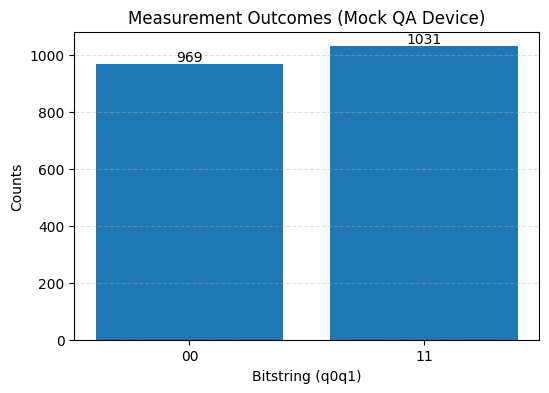

In [10]:
def plot_histogram(counts: Dict[str, int], title: str = "Measurement Outcomes (Mock QA Device)"):
    labels = sorted(counts.keys())
    values = [counts[k] for k in labels]

    plt.figure(figsize=(6,4))
    plt.bar(labels, values)  # No explicit colors/styles per instructions
    plt.xlabel("Bitstring (q0q1)")
    plt.ylabel("Counts")
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    for x, v in zip(labels, values):
        plt.text(x, v, str(v), ha="center", va="bottom", fontsize=10)
    plt.show()

plot_histogram(qa_result.counts)


## End-to-End Helper (Optional)
Convenience wrapper to re-run all steps.


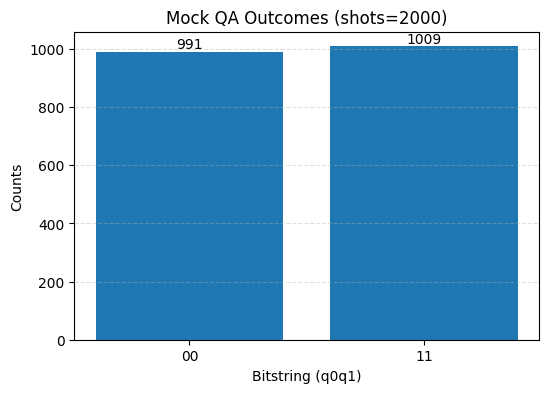


Summary:
P(00)+P(11) ≈ 1.000
Classical fidelity (hist) ≈ 1.000


In [11]:
def run_end_to_end(shots: int = 2000):
    # 1) Build circuit
    circuit = build_bell_circuit()
    # 2) Export QASM & payload
    qasm = circuit_to_qasm(circuit)
    payload = build_job_payload(qasm, shots=shots)
    # 3) "Execute" via ideal probabilities
    probs = ideal_phi_plus_probs()
    counts = sample_from_distribution(probs, shots)
    result_json = make_mock_device_response(counts, shots)
    result = QAResult.from_payload(result_json)
    # 4) Interpret
    empirical = normalize_counts(result.counts)
    mass = empirical.get("00", 0.0) + empirical.get("11", 0.0)
    f = classical_fidelity(empirical, probs)
    # 5) Visualize
    plot_histogram(result.counts, title=f"Mock QA Outcomes (shots={shots})")
    return {
        "circuit": circuit,
        "qasm": qasm,
        "payload": payload,
        "counts": result.counts,
        "empirical_probs": empirical,
        "expected_mass_00_11": mass,
        "classical_fidelity_hist": f
    }

# Demo run (safe: no simulators used)
summary = run_end_to_end(shots=2000)
print("\nSummary:")
print(f"P(00)+P(11) ≈ {summary['expected_mass_00_11']:.3f}")
print(f"Classical fidelity (hist) ≈ {summary['classical_fidelity_hist']:.3f}")


## What to Submit (Quick Checklist)

- **This notebook (.ipynb)** containing:
  - Cirq circuit that prepares $|\Phi^+\rangle$
  - QASM export cell
  - JSON payload cell
  - Mock "device execution" using ideal probabilities (no simulators)
  - Interpretation + histogram plot

**Replace** placeholders (API URL, token) with real values when you have Quokka access.


## Quokka Execution (Starter-Notebook Pattern)

This cell mirrors **Copy_of_Quokka_Start_Here.ipynb**:
- `program` holds the OpenQASM string
- POST to `http://quokka1.quokkacomputing.com/qsim/qasm` with JSON `{ 'script': program, 'count': shots }`
- Flexible parsing of response to extract counts


In [12]:
# --- Quokka execution using starter-notebook pattern ---
import json, requests, collections

# 1) Generate QASM string from our Cirq circuit
program = circuit_to_qasm(build_bell_circuit())  # QASM string

# 2) Endpoint exactly as in the starter notebook
my_quokka = 'quokka1'
request_http = f'http://{my_quokka}.quokkacomputing.com/qsim/qasm'

# 3) Build payload exactly like the starter: {'script': program, 'count': N}
shots = 200  # small test
data = {'script': program, 'count': shots}

print('POSTing to:', request_http)
resp = requests.post(request_http, json=data, verify=False, timeout=60)
print('Status:', resp.status_code)

try:
    device_json = resp.json()
except Exception:
    device_json = {'raw_text': resp.text}

print('Response (trunc):\n', json.dumps(device_json, indent=2)[:1000], '...')

# Extract counts from common keys
counts = None
shots_returned = shots
if isinstance(device_json, dict):
    if 'counts' in device_json and isinstance(device_json['counts'], dict):
        counts = {str(k): int(v) for k, v in device_json['counts'].items()}
        if 'shots' in device_json: shots_returned = int(device_json['shots'])
    elif 'results' in device_json and isinstance(device_json['results'], dict) and 'counts' in device_json['results']:
        res = device_json['results']
        counts = {str(k): int(v) for k, v in res['counts'].items()}
        if 'shots' in res: shots_returned = int(res['shots'])
    elif 'result' in device_json and isinstance(device_json['result'], list):
        c = collections.Counter(str(x) for x in device_json['result'])
        counts = dict(c); shots_returned = sum(c.values())

if counts:
    qa_like = {'results': {'counts': counts, 'shots': shots_returned}}
    result_obj = QAResult.from_payload(qa_like)
    emp = normalize_counts(result_obj.counts)
    expected_mass = emp.get('00', 0.0) + emp.get('11', 0.0)
    print(f"P(00)+P(11): {expected_mass:.3f}")
    plot_histogram(result_obj.counts, title='Measurement Outcomes (Quokka Pattern)')
else:
    print('Could not parse counts from response.')

POSTing to: http://quokka1.quokkacomputing.com/qsim/qasm


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'quokka1.quokkacomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Status: 200
Response (trunc):
 {
  "error": "no error",
  "error_code": 0,
  "result": {
    "m_m": [
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        1,
        1
      ],
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        1,
        1
      ],
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        0,
        0
      ],
      [
        0,
        0
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        0,
        0
      ],
      [
        1,
        1
      ],
      [
        1,
        1
      ],
      [
        0,
     